## **GET DATA**

In [1]:
import opendatasets as od
dataset_url = 'https://www.kaggle.com/datasets/yasserh/instacart-online-grocery-basket-analysis-dataset'
od.download(dataset_url)

Skipping, found downloaded files in "./instacart-online-grocery-basket-analysis-dataset" (use force=True to force download)


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime
import re

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
aisles_df = pd.read_csv("instacart-online-grocery-basket-analysis-dataset/aisles.csv")
departments_df = pd.read_csv("instacart-online-grocery-basket-analysis-dataset/departments.csv")
order_products_prior_df = pd.read_csv("instacart-online-grocery-basket-analysis-dataset/order_products__prior.csv")
order_products_train_df = pd.read_csv("instacart-online-grocery-basket-analysis-dataset/order_products__train.csv")
orders_df = pd.read_csv("instacart-online-grocery-basket-analysis-dataset/orders.csv")
products_df = pd.read_csv("instacart-online-grocery-basket-analysis-dataset/products.csv")

In [17]:
def count_plot(df, col):
    fig, ax = plt.subplots(figsize=(10, 3))  # Use 'ax' to plot
    sns.histplot(df[col], ax=ax, color='steelblue', stat="count")
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()

def rank(df, col, lookup_df):
    counts = df[col].value_counts().reset_index()
    print(f'Total has {len(counts)} distinct values in {col}.')
    counts = counts.head(20)
    counts.columns = ['id', 'counts']
    diction = lookup_df.set_index(lookup_df.columns[0])[lookup_df.columns[1]].to_dict()
    counts['name'] = counts['id'].map(diction)
    counts.set_index('id', inplace=True)
    ranking = counts.sort_values(by='counts', ascending=False)
    return ranking

## **EDA**

In [6]:
aisles_df.head()

aisle_id                       aisle
0         1       prepared soups salads
1         2           specialty cheeses
2         3         energy granola bars
3         4               instant foods
4         5  marinades meat preparation

In [7]:
aisles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   aisle_id  134 non-null    int64 
 1   aisle     134 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.2+ KB


#### **Departments Info**

In [8]:
departments_df.head()

department_id department
0              1     frozen
1              2      other
2              3     bakery
3              4    produce
4              5    alcohol

In [9]:
departments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   department_id  21 non-null     int64 
 1   department     21 non-null     object
dtypes: int64(1), object(1)
memory usage: 468.0+ bytes


#### **Products Info**

In [10]:
products_df.head()

product_id                                       product_name  aisle_id  \
0           1                         Chocolate Sandwich Cookies        61   
1           2                                   All-Seasons Salt       104   
2           3               Robust Golden Unsweetened Oolong Tea        94   
3           4  Smart Ones Classic Favorites Mini Rigatoni Wit...        38   
4           5                          Green Chile Anytime Sauce         5   

   department_id  
0             19  
1             13  
2              7  
3              1  
4             13

In [14]:
products_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     49688 non-null  int64 
 1   product_name   49688 non-null  object
 2   aisle_id       49688 non-null  int64 
 3   department_id  49688 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [15]:
products_df2 = pd.merge(products_df, aisles_df, on='aisle_id')
products_df2 = pd.merge(products_df2, departments_df, on='department_id')
products_df2.head()

product_id                                    product_name  aisle_id  \
0           1                      Chocolate Sandwich Cookies        61   
1          78               Nutter Butter Cookie Bites Go-Pak        61   
2         102                           Danish Butter Cookies        61   
3         172  Gluten Free All Natural Chocolate Chip Cookies        61   
4         285                    Mini Nilla Wafers Munch Pack        61   

   department_id          aisle department  
0             19  cookies cakes     snacks  
1             19  cookies cakes     snacks  
2             19  cookies cakes     snacks  
3             19  cookies cakes     snacks  
4             19  cookies cakes     snacks

<Figure size 2000x800 with 0 Axes>

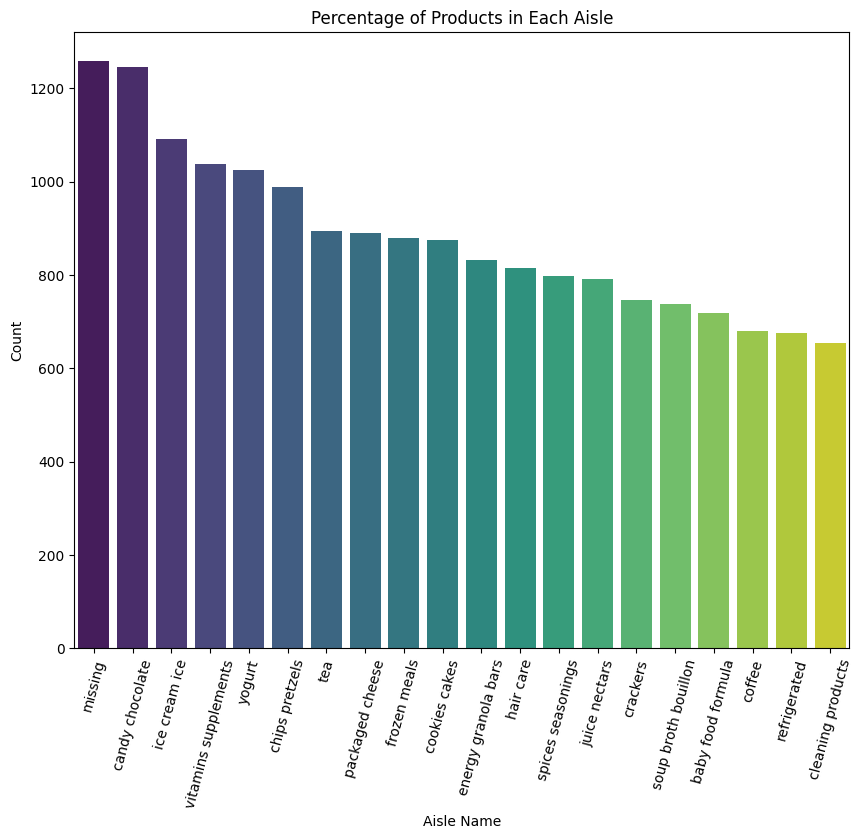

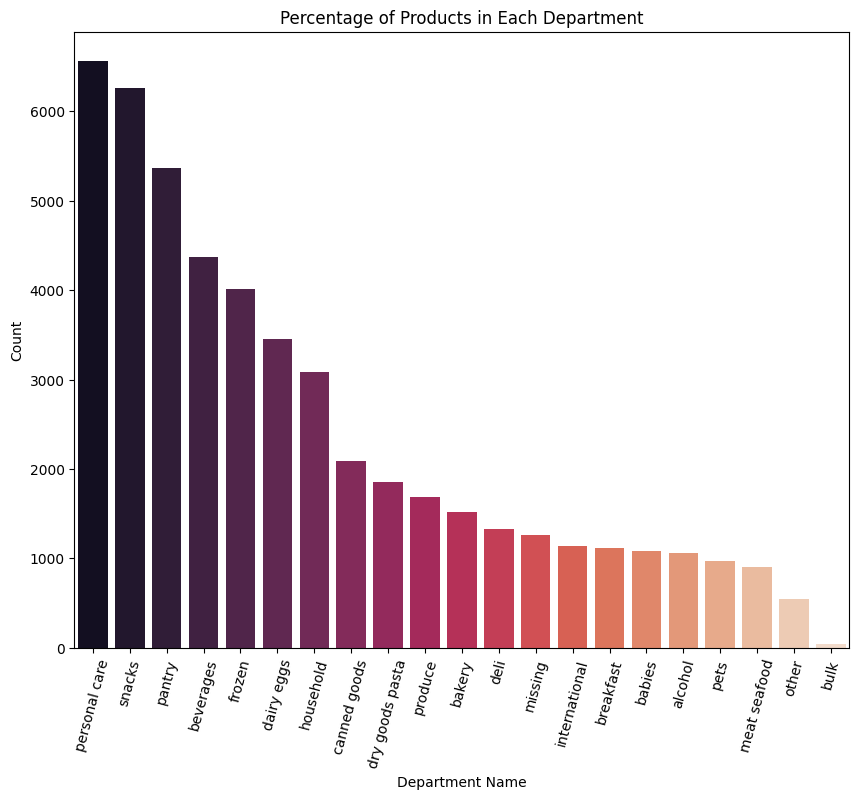

In [18]:
plt.figure(figsize=(20, 8))

department_counts = products_df2['department'].value_counts()
aisle_counts = products_df2['aisle'].value_counts()

# Distribution of aisles across products
plt.figure(figsize=(10, 8))
top_n = 20  # Choose top N aisles to display due to large number of aisles
sns.barplot(y=aisle_counts.values[:top_n], x=aisle_counts.index[:top_n], palette="viridis")
plt.title('Percentage of Products in Each Aisle')
plt.xlabel('Aisle Name')
plt.ylabel('Count')
plt.xticks(rotation=75)
plt.show()

# Distribution of departments across products
plt.figure(figsize=(10, 8))
sns.barplot(y=department_counts.values, x=department_counts.index, palette="rocket")
plt.title('Percentage of Products in Each Department')
plt.xlabel('Department Name')
plt.ylabel('Count')
plt.xticks(rotation=75)
plt.show()

#### **Orders Info**

In [19]:
print(order_products_prior_df.shape)
print(order_products_train_df.shape)
print(orders_df.shape)

(32434489, 4)
(1384617, 4)
(3421083, 7)


In [20]:
orders_df.head()

order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2398795        1    prior             2          3                  7   
2    473747        1    prior             3          3                 12   
3   2254736        1    prior             4          4                  7   
4    431534        1    prior             5          4                 15   

   days_since_prior_order  
0                     NaN  
1                    15.0  
2                    21.0  
3                    29.0  
4                    28.0

In [21]:
orders_df['eval_set'].value_counts()

eval_set
prior    3214874
train     131209
test       75000
Name: count, dtype: int64

In [22]:
orders_df = orders_df[orders_df['eval_set'].isin(['prior', 'train'])]

In [23]:
order_products_prior_df.head()

order_id  product_id  add_to_cart_order  reordered
0         2       33120                  1          1
1         2       28985                  2          1
2         2        9327                  3          0
3         2       45918                  4          1
4         2       30035                  5          0

In [24]:
# Example of order_id = 2539329
order_products_prior_df[order_products_prior_df['order_id']==2539329]

order_id  product_id  add_to_cart_order  reordered
24076664   2539329         196                  1          0
24076665   2539329       14084                  2          0
24076666   2539329       12427                  3          0
24076667   2539329       26088                  4          0
24076668   2539329       26405                  5          0

##### **Check Missing Data**
- Fill ```days_since_prior_order``` as 0.0 for first orders

In [25]:
print(orders_df.isnull().sum())
orders_df.fillna(0, inplace=True)
orders_df.head()

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64


order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2398795        1    prior             2          3                  7   
2    473747        1    prior             3          3                 12   
3   2254736        1    prior             4          4                  7   
4    431534        1    prior             5          4                 15   

   days_since_prior_order  
0                     0.0  
1                    15.0  
2                    21.0  
3                    29.0  
4                    28.0

In [26]:
orders_df['user_id'].value_counts()

user_id
112841    100
174555    100
73676     100
176469    100
90584     100
         ... 
157043      3
28893       3
28891       3
157060      3
141414      3
Name: count, Length: 206209, dtype: int64

NOTE: ***Total number of users: 206209***



#### **Join all data into one table**

In [27]:
# Join prior and train data
combined_order_products_df = pd.concat([order_products_prior_df, order_products_train_df])

# Join order_products with products info --> add aisles and departments
full_order_products_df = pd.merge(combined_order_products_df, products_df2, on='product_id')

# Join with orders_df to have one table of all information
instacart_df = pd.merge(full_order_products_df, orders_df, on='order_id')

In [28]:
print(instacart_df.shape)
print(instacart_df.columns)

(33819106, 15)
Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered',
       'product_name', 'aisle_id', 'department_id', 'aisle', 'department',
       'user_id', 'eval_set', 'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order'],
      dtype='object')


### **Features Engineering for User-centered Dataset**

In [29]:
"""
** Numerical data
"""
# Total Orders
total_orders_per_user = orders_df.groupby('user_id')['order_number'].max()

# Average Order Size
total_items_per_user = instacart_df.groupby('user_id').size()
avg_order_size = round(total_items_per_user/total_orders_per_user, 0)

# Average Days Between Orders
avg_days_between_orders_per_user = orders_df.groupby('user_id')['days_since_prior_order'].mean().round()

# Reorder Rate: average reordered time per user
reorder_rate_per_user = instacart_df.groupby('user_id')['reordered'].mean().round(2)

"""
** Categorical data
"""
# Preferred Order Day
preferred_order_dow_per_user = orders_df.groupby('user_id')['order_dow'].agg(lambda x: x.mode()[0])

# Preferred Order Time
preferred_order_hour_per_user = orders_df.groupby('user_id')['order_hour_of_day'].agg(lambda x: x.mode()[0])

# Preferred Aisle
fav_aisle_per_user = instacart_df.groupby('user_id')['aisle_id'].agg(lambda x: x.mode()[0])

# Preferred Department
fav_department_per_user = instacart_df.groupby('user_id')['department_id'].agg(lambda x: x.mode()[0])

In [30]:
# Add all featurs to users_df
users_df = pd.DataFrame({
    'total_orders': total_orders_per_user,
    'avg_order_size': avg_order_size,
    'avg_days_between_orders': avg_days_between_orders_per_user,
    'reorder_rate': reorder_rate_per_user,
    'fav_order_dow': preferred_order_dow_per_user,
    'fav_order_hour': preferred_order_hour_per_user,
    'fav_aisle': fav_aisle_per_user,
    'fav_department': fav_department_per_user
}).reset_index()

users_df.head()

user_id  total_orders  avg_order_size  avg_days_between_orders  \
0        1            11             6.0                     17.0   
1        2            15            15.0                     15.0   
2        3            12             7.0                     11.0   
3        4             5             4.0                     11.0   
4        5             5             9.0                      9.0   

   reorder_rate  fav_order_dow  fav_order_hour  fav_aisle  fav_department  
0          0.73              4               7         77              19  
1          0.46              1              10        120              16  
2          0.62              0              16         24               4  
3          0.06              4              11         38               1  
4          0.39              0              18        123               4

In [31]:
print(users_df.isnull().sum())

user_id                    0
total_orders               0
avg_order_size             0
avg_days_between_orders    0
reorder_rate               0
fav_order_dow              0
fav_order_hour             0
fav_aisle                  0
fav_department             0
dtype: int64


In [32]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206209 entries, 0 to 206208
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   user_id                  206209 non-null  int64  
 1   total_orders             206209 non-null  int64  
 2   avg_order_size           206209 non-null  float64
 3   avg_days_between_orders  206209 non-null  float64
 4   reorder_rate             206209 non-null  float64
 5   fav_order_dow            206209 non-null  int64  
 6   fav_order_hour           206209 non-null  int64  
 7   fav_aisle                206209 non-null  int64  
 8   fav_department           206209 non-null  int64  
dtypes: float64(3), int64(6)
memory usage: 14.2 MB


In [33]:
users_df.set_index('user_id', inplace=True)

In [34]:
# Copy data to users, and work on users, users_df as it is
users = users_df.copy()

In [35]:
users.head()

total_orders  avg_order_size  avg_days_between_orders  reorder_rate  \
user_id                                                                        
1                  11             6.0                     17.0          0.73   
2                  15            15.0                     15.0          0.46   
3                  12             7.0                     11.0          0.62   
4                   5             4.0                     11.0          0.06   
5                   5             9.0                      9.0          0.39   

         fav_order_dow  fav_order_hour  fav_aisle  fav_department  
user_id                                                            
1                    4               7         77              19  
2                    1              10        120              16  
3                    0              16         24               4  
4                    4              11         38               1  
5                    0              18        123               4

In [31]:
cat_cols = ['fav_order_dow', 'fav_order_hour', 'fav_aisle', 'fav_department']
num_cols = ['total_orders', 'avg_order_size', 'avg_days_between_orders', 'reorder_rate']

#### **Visualization**

#### *1. Categorical Data*

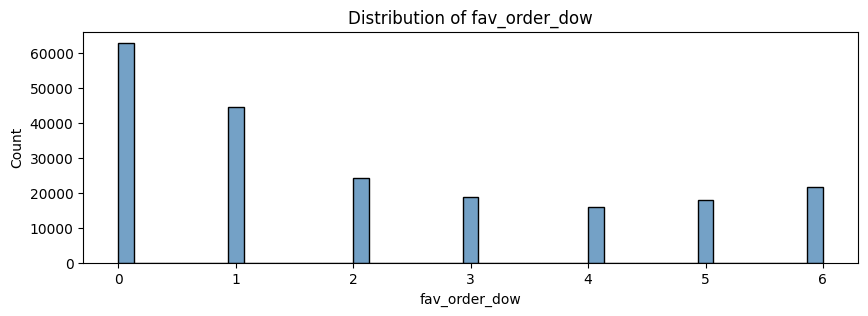

In [32]:
count_plot(users, 'fav_order_dow')

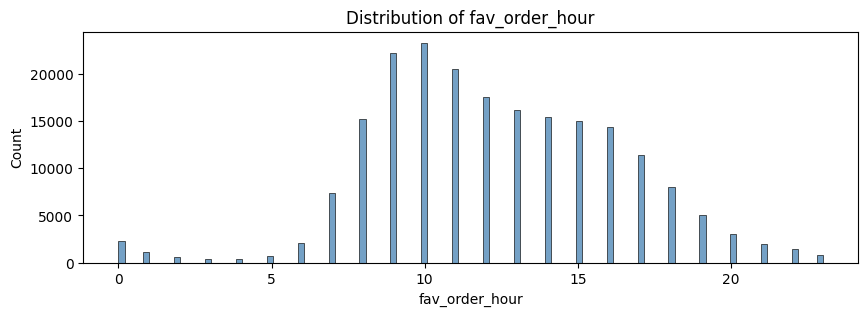

In [33]:
count_plot(users, 'fav_order_hour')

In [34]:
def categorize_hour(hour):
    if 5 <= hour <= 11:
        return 'morning'
    elif 12 <= hour <= 16:
        return 'afternoon'
    elif 17 <= hour <= 20:
        return 'evening'
    else:
        return 'late_night'

# favorite order time of day
users['fav_order_tod'] = users['fav_order_hour'].apply(categorize_hour)
users.drop(columns=['fav_order_hour'], inplace=True)

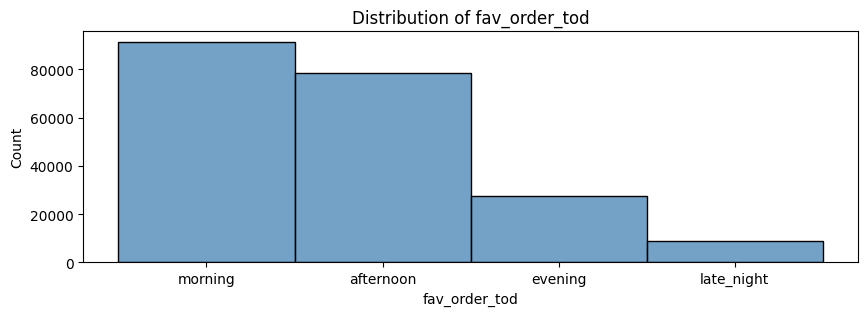

In [35]:
count_plot(users, 'fav_order_tod')

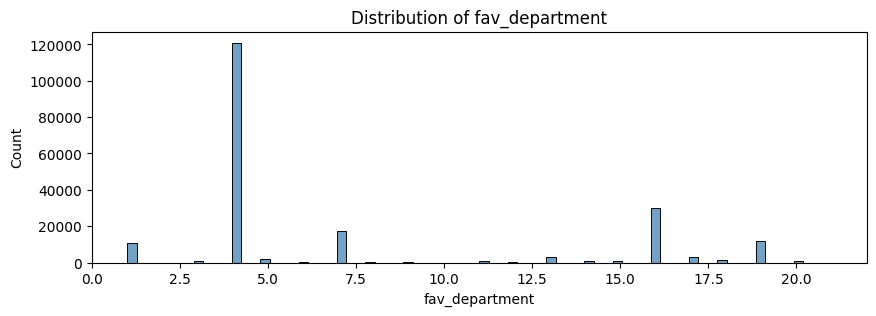

Total has 21 distinct values in fav_department.
Top 20
               name  counts
id                         
4           produce  120955
16       dairy eggs   29751
7         beverages   17156
19           snacks   12101
1            frozen   10794
13           pantry    3229
17        household    3011
5           alcohol    2106
18           babies    1223
11    personal care    1144
3            bakery    1039
15     canned goods     867
20             deli     660
14        breakfast     640
9   dry goods pasta     518
8              pets     481
12     meat seafood     417
6     international      75
2             other      20
21          missing      15


In [36]:
count_plot(users, 'fav_department')
rank(users, 'fav_department', departments_df)

In [37]:
dept_counts = users['fav_department'].value_counts()
rare_dept = dept_counts[dept_counts < 12000].index 
users['fav_dept_aggregated'] = users['fav_department'].replace(rare_dept, -1)
users.drop(columns=['fav_department'], inplace=True)
users['fav_dept_aggregated'].value_counts()

fav_dept_aggregated
 4     120955
 16     29751
-1      26246
 7      17156
 19     12101
Name: count, dtype: int64

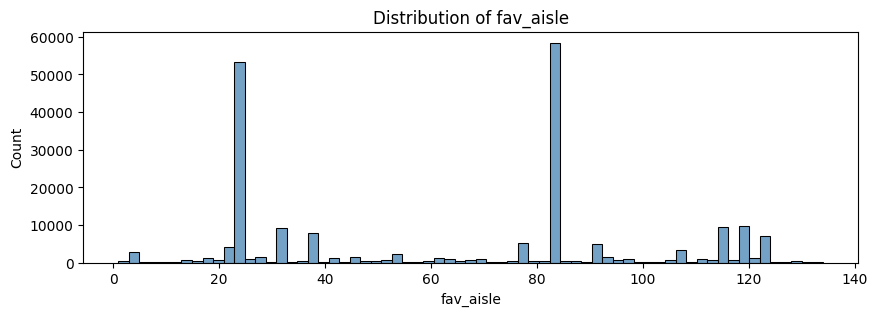

Total has 133 distinct values in fav_aisle.
Top 20
                              name  counts
id                                        
83                fresh vegetables   55101
24                    fresh fruits   52828
120                         yogurt    9757
115  water seltzer sparkling water    8092
123     packaged vegetables fruits    6636
32                packaged produce    5822
38                    frozen meals    4264
21                 packaged cheese    4139
77                     soft drinks    4065
37                   ice cream ice    3650
31                    refrigerated    3455
84                            milk    3363
92               baby food formula    3208
107                 chips pretzels    3120
3              energy granola bars    2339
91                 soy lactosefree    1798
45                 candy chocolate    1477
54                     paper goods    1380
116                 frozen produce    1306
17              baking ingredients    1232


In [38]:
count_plot(users, 'fav_aisle')
rank(users, 'fav_aisle', aisles_df)

In [39]:
aisle_counts = users['fav_aisle'].value_counts()
rare_aisles = aisle_counts[aisle_counts < 6000].index
users['fav_aisle_aggregated'] = users['fav_aisle'].replace(rare_aisles, -1)
users.drop(columns=['fav_aisle'], inplace=True)
users['fav_aisle_aggregated'].value_counts()

fav_aisle_aggregated
-1      73795
 83     55101
 24     52828
 120     9757
 115     8092
 123     6636
Name: count, dtype: int64

In [40]:
cat_cols = ['fav_order_dow', 'fav_order_tod', 'fav_aisle_aggregated', 'fav_dept_aggregated']
num_cols = ['total_orders', 'avg_order_size', 'avg_days_between_orders', 'reorder_rate']

#### *2. Numercial Data*

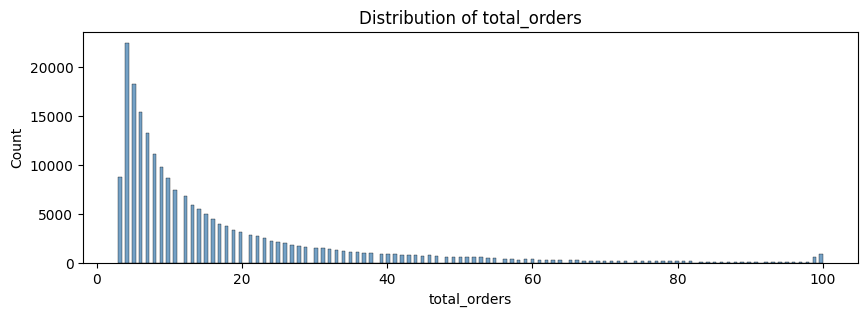

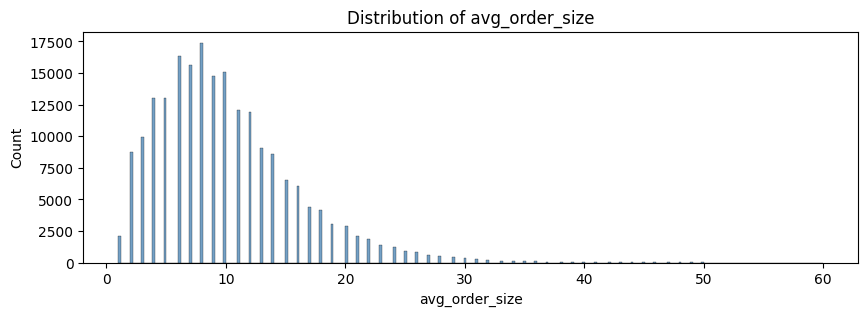

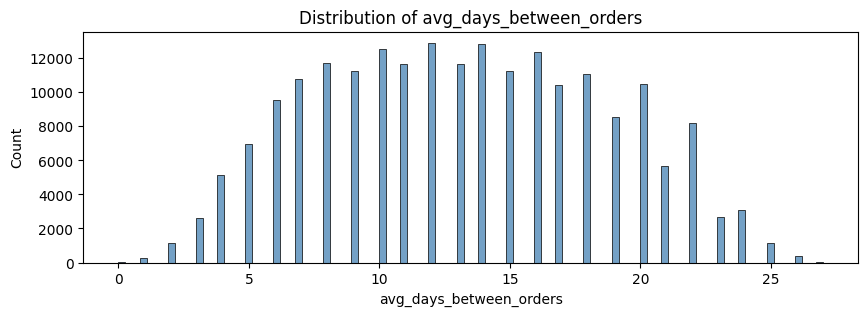

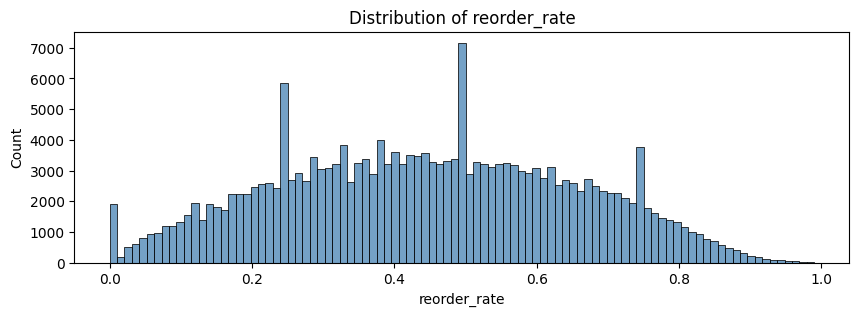

In [41]:
for col in num_cols:
    count_plot(users, col)

#### *3. Association Between Categorical and Numerical Data*

In [42]:
# pip install dython

In [43]:
from dython.nominal import associations # type: ignore

In [44]:
corr_matrix = associations(users, compute_only=True)

In [45]:
corr_matrix

{'corr':                          total_orders  avg_order_size  \
 total_orders                 1.000000        0.020411   
 avg_order_size               0.020411        1.000000   
 avg_days_between_orders     -0.517535       -0.014169   
 reorder_rate                 0.625574        0.115604   
 fav_order_dow                0.035404       -0.049282   
 fav_order_tod                0.041252        0.035477   
 fav_dept_aggregated          0.032301       -0.010812   
 fav_aisle_aggregated         0.051649        0.177957   
 
                          avg_days_between_orders  reorder_rate  fav_order_dow  \
 total_orders                           -0.517535      0.625574       0.035404   
 avg_order_size                         -0.014169      0.115604      -0.049282   
 avg_days_between_orders                 1.000000     -0.347954      -0.044004   
 reorder_rate                           -0.347954      1.000000       0.025246   
 fav_order_dow                          -0.044004      0.0

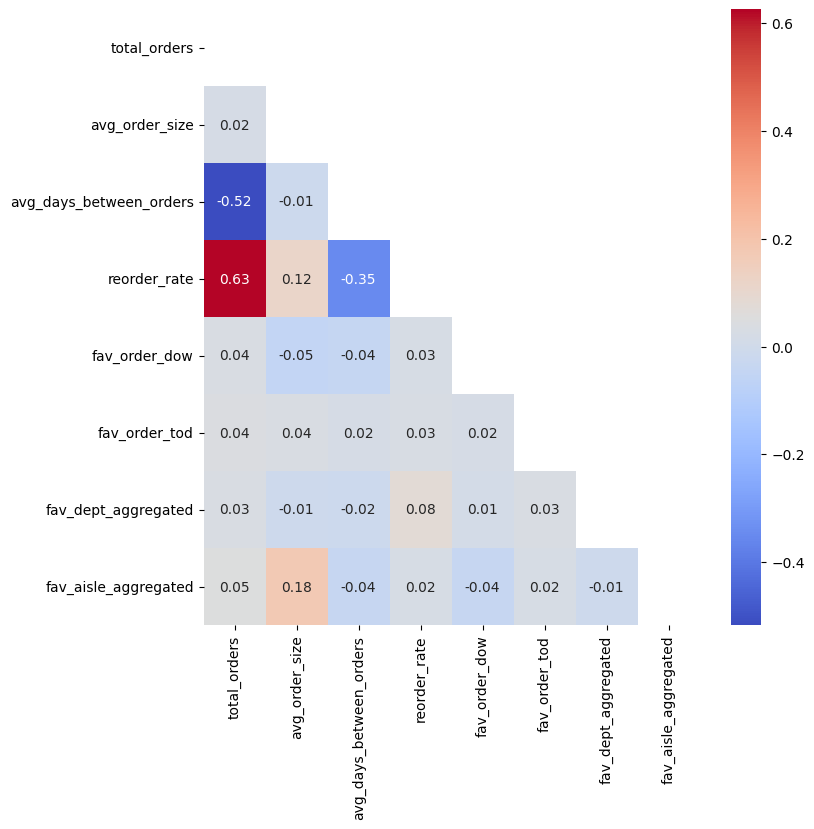

In [46]:
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(corr_matrix['corr'], mask=np.triu(corr_matrix['corr']), 
            annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

##### ***Note:***
- `reorder_rate` has a relatively strong positive association with `total_orders`: users who order more frequently may tend to reorder items.

- `avg_days_between_orders` has a strong negative association with `total_orders`: users who order more frequently have shorter intervals between orders.

- `fav_aisle` and `fav_department` show a moderate positive association: certain aisles and departments are more frequently favored together by users.

## **Unsupervised Learning**
- Customer Segmentation
- Model: K-Prototypes


In [47]:
users_kp = users.copy()

In [48]:
from sklearn.preprocessing import OrdinalEncoder # type: ignore
from sklearn.preprocessing import StandardScaler # type: ignore
from kmodes.kprototypes import KPrototypes # type: ignore

#### **Data Preprocessing**
- Numerical data: only accepts floating-point values - apply StandardScaler()
- Categorical data: integer values, encode if needed

In [49]:
users_kp.dtypes

total_orders                 int64
avg_order_size             float64
avg_days_between_orders    float64
reorder_rate               float64
fav_order_dow                int64
fav_order_tod               object
fav_dept_aggregated          int64
fav_aisle_aggregated         int64
dtype: object

In [50]:
scaler = StandardScaler()
users_kp[num_cols] = scaler.fit_transform(users_kp[num_cols])

In [51]:
encoder = OrdinalEncoder()
users_kp['fav_order_tod'] = encoder.fit_transform(users_kp[['fav_order_tod']])

users_kp[cat_cols] = users_kp[cat_cols].astype('int64')
cat_col_indices = [users_kp.columns.get_loc(col) for col in cat_cols]
print(cat_col_indices)

[4, 5, 7, 6]


In [52]:
print(users['fav_order_tod'].value_counts())
print(users_kp['fav_order_tod'].value_counts())

fav_order_tod
morning       91200
afternoon     78461
evening       27495
late_night     9053
Name: count, dtype: int64
fav_order_tod
3    91200
0    78461
1    27495
2     9053
Name: count, dtype: int64


In [53]:
users_kp.dtypes

total_orders               float64
avg_order_size             float64
avg_days_between_orders    float64
reorder_rate               float64
fav_order_dow                int64
fav_order_tod                int64
fav_dept_aggregated          int64
fav_aisle_aggregated         int64
dtype: object

#### **Base Model: K-Prototypes with 2 clusters**

In [54]:
# pip install kmodes

In [55]:
kp = KPrototypes(n_clusters=2, init='Huang', random_state=42, verbose=1)


In [56]:
kp_clusters = kp.fit_predict(users_kp, categorical=cat_col_indices)

Init: initializing centroids
Init: initializing clusters
Starting iterations...


Run: 1, iteration: 1/100, moves: 16110, ncost: 794636.2883619963
Run: 1, iteration: 2/100, moves: 6498, ncost: 793407.250936053
Run: 1, iteration: 3/100, moves: 2180, ncost: 793238.5288377329
Run: 1, iteration: 4/100, moves: 937, ncost: 793206.1695116917
Run: 1, iteration: 5/100, moves: 438, ncost: 793198.8549789436
Run: 1, iteration: 6/100, moves: 247, ncost: 793196.4951380934
Run: 1, iteration: 7/100, moves: 132, ncost: 793195.8361438577
Run: 1, iteration: 8/100, moves: 78, ncost: 793195.619525328
Run: 1, iteration: 9/100, moves: 45, ncost: 793195.5305759979
Run: 1, iteration: 10/100, moves: 19, ncost: 793195.5165934609
Run: 1, iteration: 11/100, moves: 6, ncost: 793195.5149570333
Run: 1, iteration: 12/100, moves: 11, ncost: 793195.5086922742
Run: 1, iteration: 13/100, moves: 9, ncost: 793195.5052363129
Run: 1, iteration: 14/100, moves: 3, ncost: 793195.5042992415
Run: 1, iteration: 15/100, moves: 4, ncost: 793195.5031283114
Run: 1, iteration: 16/100, moves: 1, ncost: 793195.50308417

In [64]:
pd.Series(kp_clusters).value_counts()

0    142486
1     63723
Name: count, dtype: int64

In [65]:
print(kp.cost_)

793195.5030841747


In [66]:
users_kp['cluster'] = kp_clusters
users_kp.columns

Index(['total_orders', 'avg_order_size', 'avg_days_between_orders',
       'reorder_rate', 'fav_order_dow', 'fav_order_tod', 'fav_dept_aggregated',
       'fav_aisle_aggregated', 'cluster'],
      dtype='object')

##### Visualization of Cluters
- Numerical Data

In [102]:
users['cluster'] = kp_clusters
users.head()

total_orders  avg_order_size  avg_days_between_orders  reorder_rate  \
user_id                                                                        
1                  11             6.0                     17.0          0.73   
2                  15            15.0                     15.0          0.46   
3                  12             7.0                     11.0          0.62   
4                   5             4.0                     11.0          0.06   
5                   5             9.0                      9.0          0.39   

         fav_order_dow fav_order_tod  fav_dept_aggregated  \
user_id                                                     
1                    4       morning                   19   
2                    1       morning                   16   
3                    0     afternoon                    4   
4                    4       morning                   -1   
5                    0       evening                    4   

         fav_aisle_aggregated  cluster  
user_id                                 
1                          -1        0  
2                         120        0  
3                          24        1  
4                          -1        0  
5                         123        0

/opt/homebrew/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



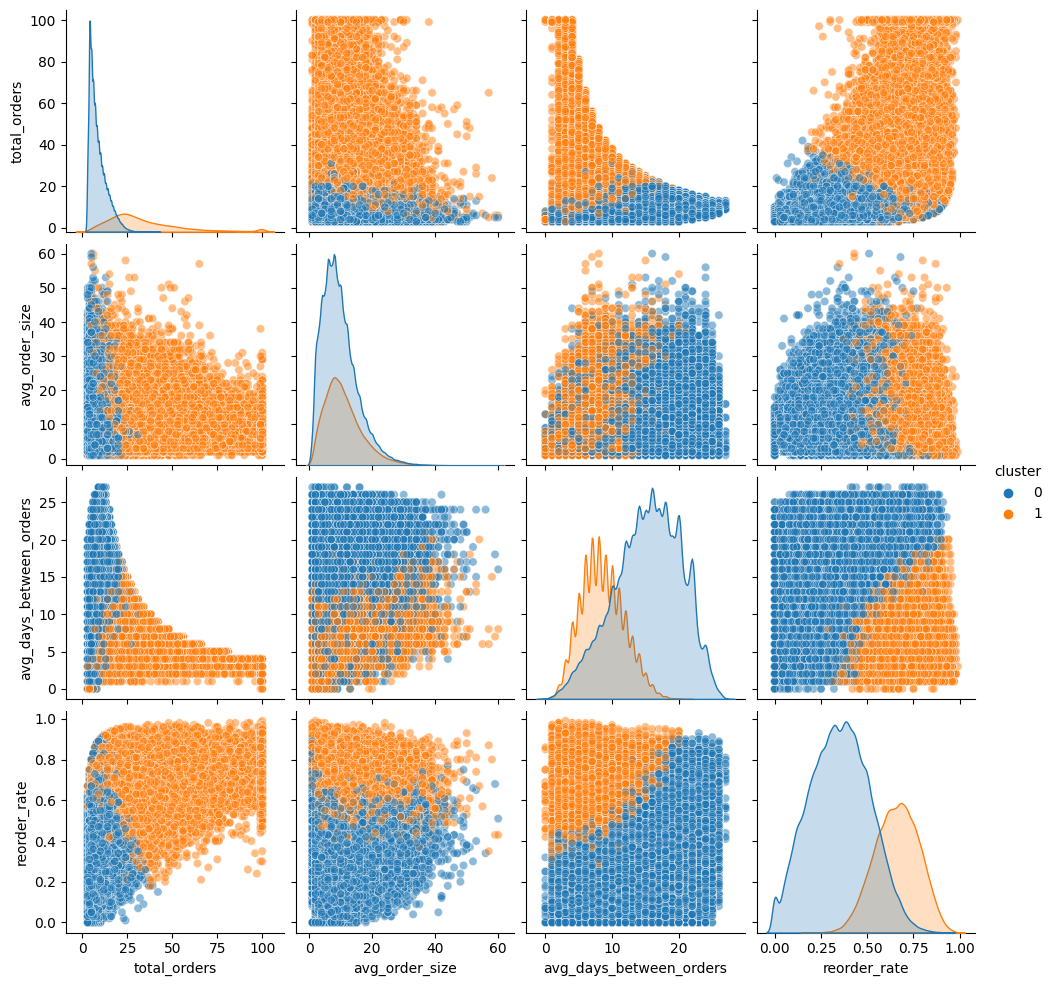

In [95]:
sns.pairplot(users[num_cols + ['cluster']], hue='cluster', diag_kind='kde', plot_kws={'alpha': 0.5})

- Categorical Data

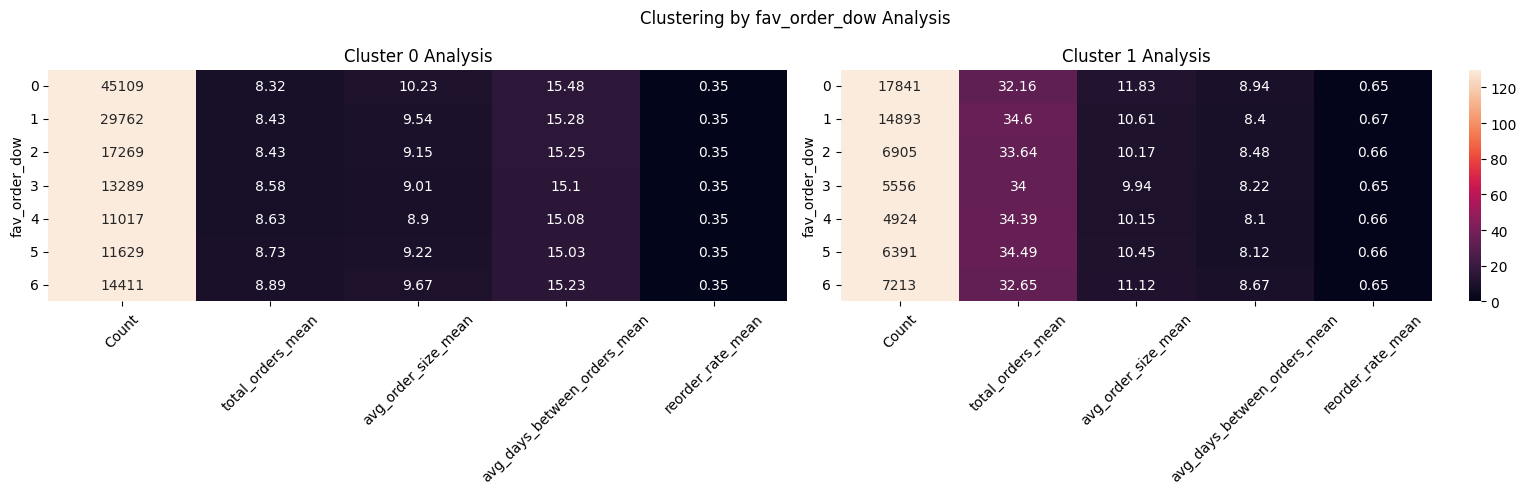

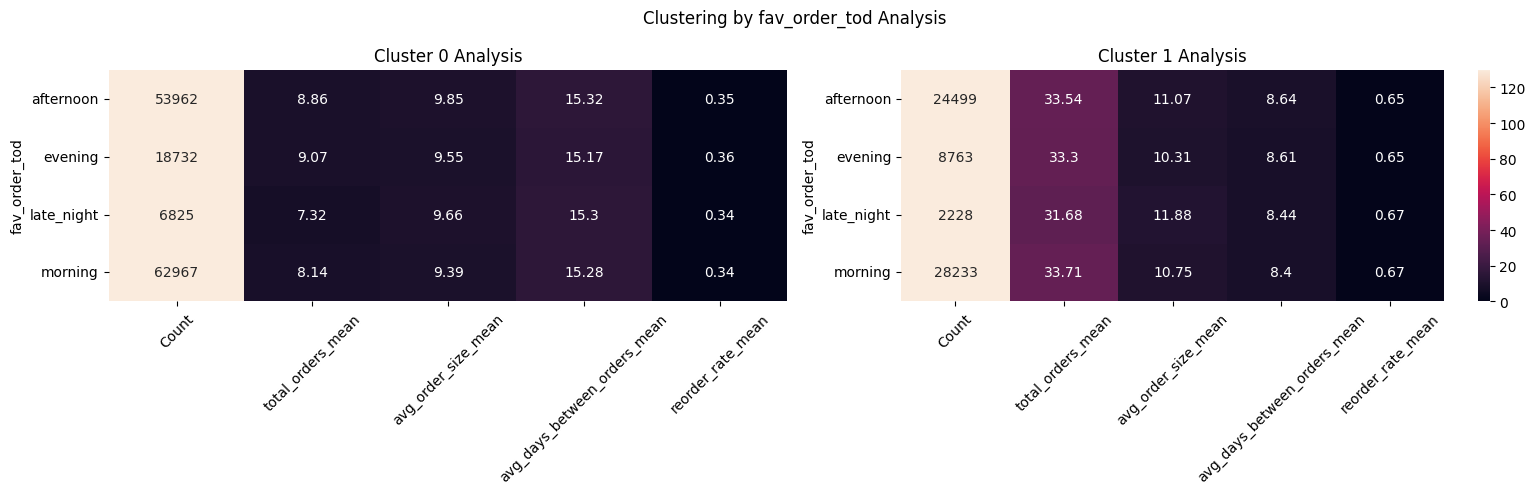

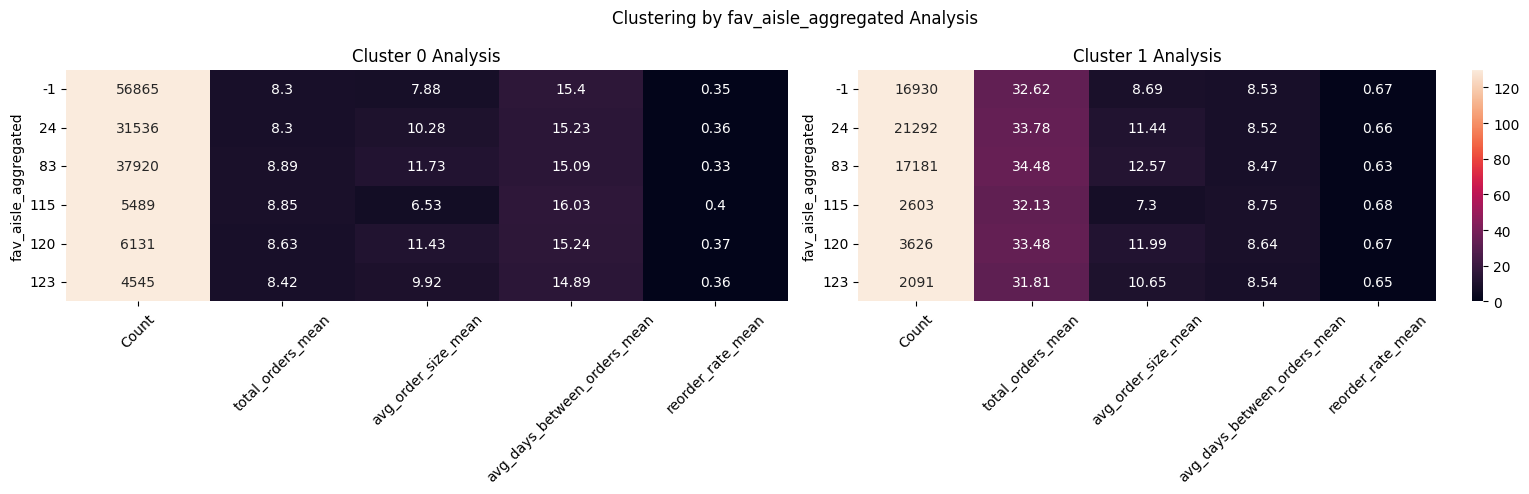

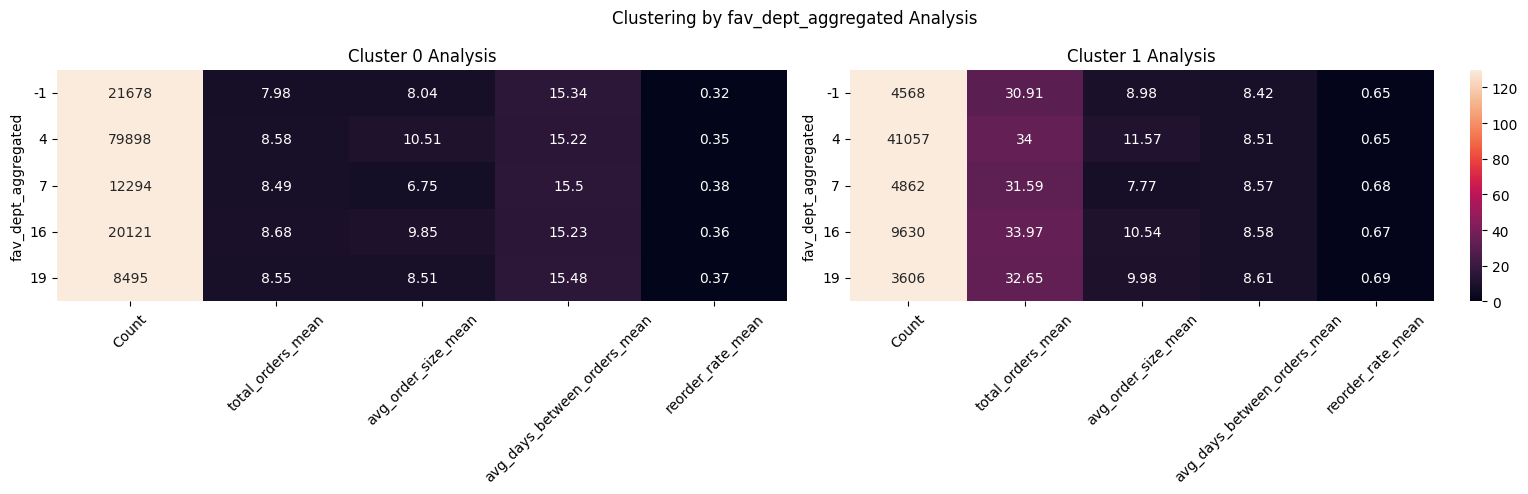

In [103]:
cat_cols = ['fav_order_dow', 'fav_order_tod', 'fav_aisle_aggregated', 'fav_dept_aggregated']

for col in cat_cols:
    fig, ax = plt.subplots(1, len(users['cluster'].unique()), figsize=(16, 5))  # Adjust the subplot count dynamically
    for i, cluster_val in enumerate(sorted(users['cluster'].unique())):
        cluster_data = users[users['cluster'] == cluster_val]
        summary_table = cluster_data.groupby(col).agg({
            'cluster': 'size',
            'total_orders': 'mean',
            'avg_order_size': 'mean', 
            'avg_days_between_orders': 'mean', 
            'reorder_rate': 'mean'
        }).rename(columns={
            'cluster': 'Count',
            'total_orders': 'total_orders_mean',
            'avg_order_size': 'avg_order_size_mean',
            'avg_days_between_orders': 'avg_days_between_orders_mean',
            'reorder_rate': 'reorder_rate_mean'
        }).round(2)

        sns.heatmap(summary_table, annot=True, fmt='g', ax=ax[i], vmin=0, vmax=130, cbar=i == len(users['cluster'].unique()) - 1)
        ax[i].set_title(f'Cluster {cluster_val} Analysis')
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45)  
        ax[i].set_yticklabels(ax[i].get_yticklabels(), rotation=0) 

    plt.suptitle(f'Clustering by {col} Analysis')
    plt.tight_layout()
    plt.show()


**Note:**
- Cluster 0: Casual Shoppers
    + high in average days between orders 
    + moderate in total orders and average order size
    + reorder rate is lower
    + favorite day: Friday, Sat, Sun
    + favorite time: morning, afternoon
    + favorite aisle: 83 - fresh vegetables
    + favorite dept: 4 - produce
- Cluster 1: Regular Buyers
    + high in total order
    + moderate in average days between orders and average order size
    + reorder rate is higher
    + favorite day: Friday, Sat, Sun
    + favorite time: morning, afternoon
    + favorite aisle: 24 - fresh fruits
    + favorite dept: 4 - produce

#### Using Elbow rule
- Test for number of clusters in range 2 to 6

In [81]:
users_kp.head()

total_orders  avg_order_size  avg_days_between_orders  reorder_rate  \
user_id                                                                        
1           -0.313684       -0.681538                 0.697864      1.384737   
2           -0.073619        0.857492                 0.331209      0.075944   
3           -0.253668       -0.510535                -0.402099      0.851525   
4           -0.673780       -1.023544                -0.402099     -1.863009   
5           -0.673780       -0.168528                -0.768754     -0.263373   

         fav_order_dow  fav_order_tod  fav_dept_aggregated  \
user_id                                                      
1                    4              3                   19   
2                    1              3                   16   
3                    0              0                    4   
4                    4              3                   -1   
5                    0              1                    4   

         fav_aisle_aggregated  cluster  
user_id                                 
1                          -1        0  
2                         120        0  
3                          24        1  
4                          -1        0  
5                         123        0

In [82]:
users_kp.drop('cluster', axis=1, inplace=True)

In [83]:
cat_col_indices

[4, 5, 7, 6]

In [85]:
costs = []
n_clusters = []

for i in range(2, 7):
    try:
        kp = KPrototypes(n_clusters= i, init='Huang', random_state=42, max_iter=20)
        clusters = kp.fit_predict(users_kp, categorical=cat_col_indices)
        costs.append(kp.cost_)
        n_clusters.append(i)
        print(f"--- {i} Clusters: Done ---\n")
    except Exception as e:
        print(f"Can't cluster with {i} clusters", e)

--- 2 Clusters: Done ---

--- 3 Clusters: Done ---

--- 4 Clusters: Done ---

--- 5 Clusters: Done ---

--- 6 Clusters: Done ---



- K-Prototypes: Number of Clusters and Cost

In [87]:
fig = go.Figure(data=go.Scatter(x=n_clusters, y=costs))
fig.update_layout(title='K-Prototypes Cost vs Number of Clusters',
                  xaxis_title='Number of Clusters',
                  yaxis_title='Cost',
                  template='plotly_white')
fig.show()

In [90]:
from kneed import KneeLocator # type: ignore
cost_knee = KneeLocator(
        x=range(2,7), 
        y=costs, 
        S=0.1, curve="convex", direction="decreasing", online=True)

K_cost = cost_knee.elbow   
print("elbow at k =", f'{K_cost:.0f} clusters')

elbow at k = 4 clusters


In [91]:
optimal_n_clusters = K_cost
print(optimal_n_clusters)

4


In [97]:
kp_final = KPrototypes(n_clusters= optimal_n_clusters, init='Huang', random_state=42, max_iter=20)
clusters1 = kp_final.fit_predict(users_kp, categorical=cat_col_indices)

print(clusters1)

[1 2 1 ... 2 0 3]


In [98]:
pd.Series(clusters1).value_counts()

3    72982
1    69075
2    38653
0    25499
Name: count, dtype: int64

In [104]:
users['cluster'] = clusters1
users.head()

total_orders  avg_order_size  avg_days_between_orders  reorder_rate  \
user_id                                                                        
1                  11             6.0                     17.0          0.73   
2                  15            15.0                     15.0          0.46   
3                  12             7.0                     11.0          0.62   
4                   5             4.0                     11.0          0.06   
5                   5             9.0                      9.0          0.39   

         fav_order_dow fav_order_tod  fav_dept_aggregated  \
user_id                                                     
1                    4       morning                   19   
2                    1       morning                   16   
3                    0     afternoon                    4   
4                    4       morning                   -1   
5                    0       evening                    4   

         fav_aisle_aggregated  cluster  
user_id                                 
1                          -1        1  
2                         120        2  
3                          24        1  
4                          -1        3  
5                         123        1

/opt/homebrew/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



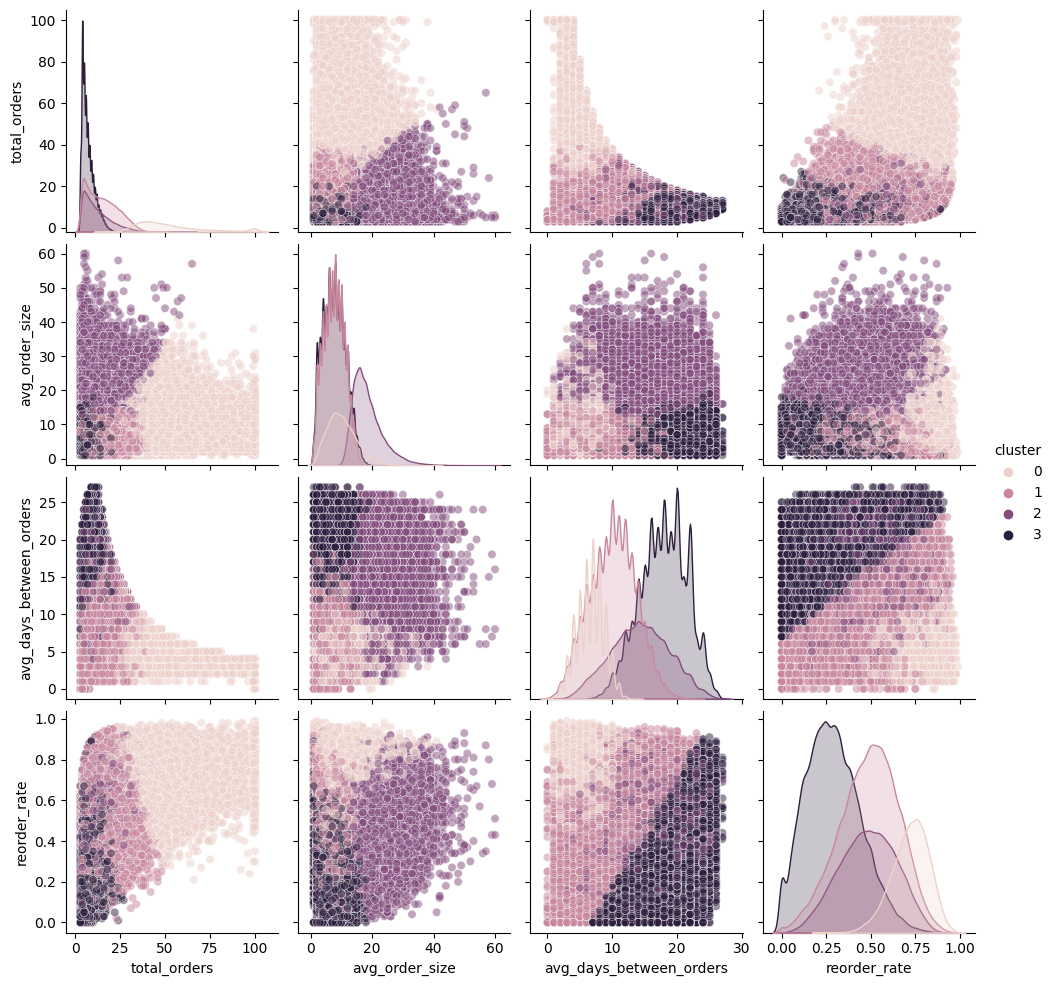

In [101]:
sns.pairplot(users[num_cols + ['cluster']], hue='cluster', diag_kind='kde', plot_kws={'alpha': 0.5})

In [111]:
stat_analysis = users[num_cols + ['cluster']]
centers = stat_analysis.groupby('cluster').mean()
centers

total_orders  avg_order_size  avg_days_between_orders  reorder_rate
cluster                                                                     
0           52.242911       10.291698                 6.631515      0.720113
1           14.846254        7.570684                10.056475      0.487733
2           12.097974       18.588958                14.286808      0.481535
3            7.136184        7.607533                17.875778      0.287199

**Note:**
| Cluster | Total Orders | Avg Order Size | Avg Days Between Orders | Reorder Rate | Group |
|---------|--------------|----------------|-------------------------|--------------|------------------|
| 0       | High         | High           | Low                     | High         | Loyal Users |
| 1       | Moderate     | Moderate       | Moderate                | Moderate     | Casual Shoppers |
| 2       | Moderate     | Very High      | High                    | Moderate     | Large-Cart Users |
| 3       | Low          | Moderate       | Very High               | Low          | Infrequent Users |


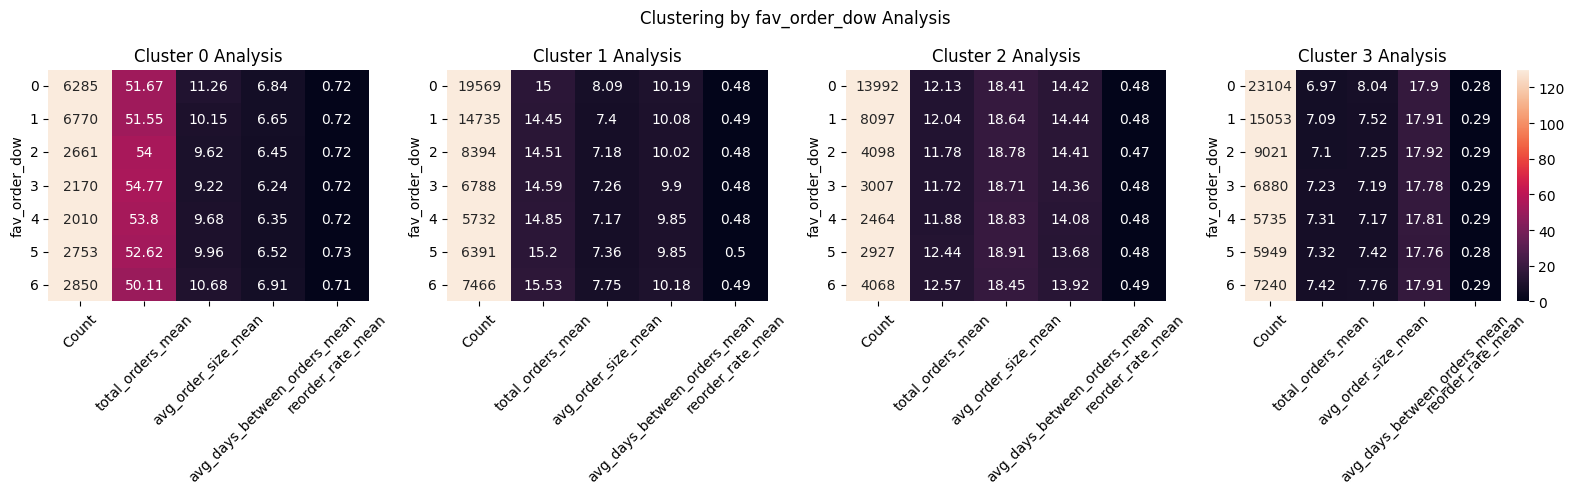

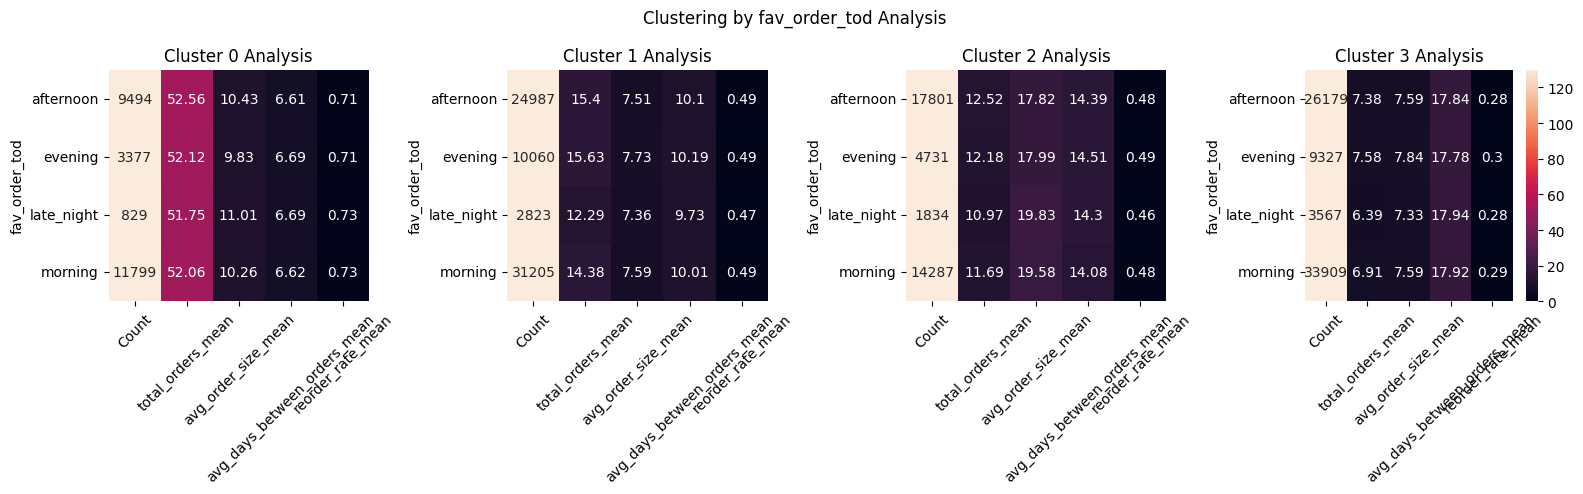

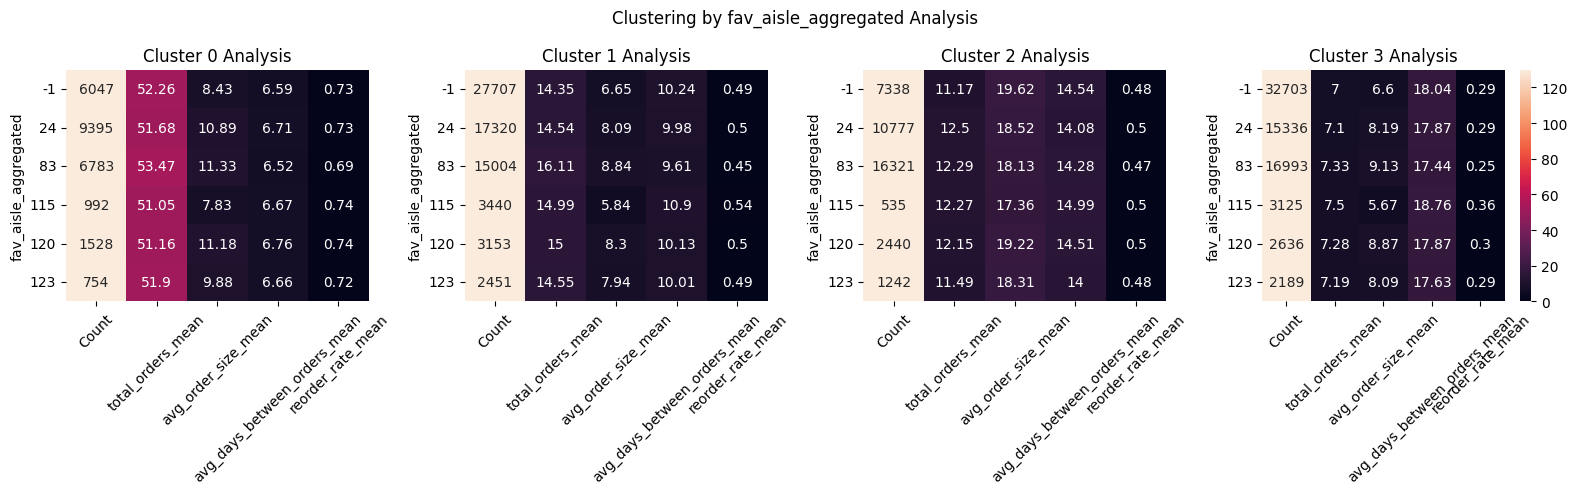

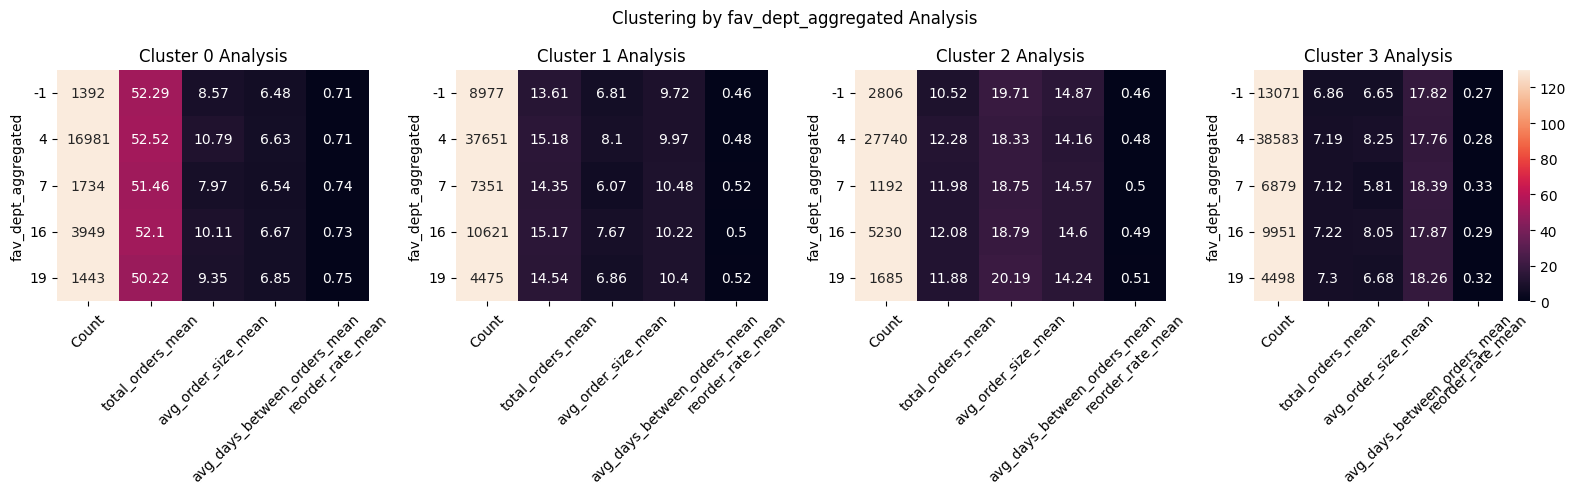

In [105]:
cat_cols = ['fav_order_dow', 'fav_order_tod', 'fav_aisle_aggregated', 'fav_dept_aggregated']

for col in cat_cols:
    fig, ax = plt.subplots(1, len(users['cluster'].unique()), figsize=(16, 5))  # Adjust the subplot count dynamically
    for i, cluster_val in enumerate(sorted(users['cluster'].unique())):
        cluster_data = users[users['cluster'] == cluster_val]
        summary_table = cluster_data.groupby(col).agg({
            'cluster': 'size',
            'total_orders': 'mean',
            'avg_order_size': 'mean', 
            'avg_days_between_orders': 'mean', 
            'reorder_rate': 'mean'
        }).rename(columns={
            'cluster': 'Count',
            'total_orders': 'total_orders_mean',
            'avg_order_size': 'avg_order_size_mean',
            'avg_days_between_orders': 'avg_days_between_orders_mean',
            'reorder_rate': 'reorder_rate_mean'
        }).round(2)

        sns.heatmap(summary_table, annot=True, fmt='g', ax=ax[i], vmin=0, vmax=130, cbar=i == len(users['cluster'].unique()) - 1)
        ax[i].set_title(f'Cluster {cluster_val} Analysis')
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45)  
        ax[i].set_yticklabels(ax[i].get_yticklabels(), rotation=0) 

    plt.suptitle(f'Clustering by {col} Analysis')
    plt.tight_layout()
    plt.show()


**Note:**
- Cluster 0: Loyal Users
    + Fav aisle: 24 
- Cluster 1: Casual Users
    + Fav aisle: 24, 83, varied
- Cluster 2: Large-Cart Users
    + Fav aisle: 24, 83
- Cluster 3: Infrequent Users
    + Fav aisle: 24, 83, varied

- In all 4 clusters:
    + Favorite day: weekend
    + Favorite time: morning and afternoon
    + Fav department: 4

In [115]:
users.to_csv('data/users.csv')

In [116]:
instacart_df.to_csv('data/instacart.csv')